Dimensionality Reduction - A notebook on how we reduce our dimensions 

In [1]:
import glob
import xarray as xr
import netCDF4
import h5netcdf
import scipy
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Please use WGET on our online data to download the data - this is from a server 
ds=xr.open_dataset('../data/ready_sic_sst_data.nc')
sst=ds.sst
sic=ds.sic

### Discuss the current dimensions of the dataset and any challenges they present

Our data is temporally sparse with only 45 samples; however, has high dimensionality in its lat-lon grid with thousands of points. It is worth noting that these points are hihgly correlated at the local scale. We reduce this spatial correlation using both EOFs aand t-SNE and seek to find areas that expain large amount of vareince that might be averaged over or reduced to. We hope to use noise to expand our 45 long sample size 1979-2023 soon. 

In [3]:
sst

<xarray.DataArray 'sst' (time: 46, latitude: 160, longitude: 1440)>
[10598400 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1979-09-01 1980-09-01 ... 2024-09-01
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... 50.75 50.5 50.25
  * longitude  (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
Attributes: (12/32)
    GRIB_paramId:                             34
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      404640
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_units:                               K
    long_name:                                Sea surface temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0
    coordinates:                              number date latitude longitude ...

In [4]:
sic

<xarray.DataArray 'sic' (time: 46, latitude: 160, longitude: 1440)>
[10598400 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1979-09-01 1980-09-01 ... 2024-09-01
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... 50.75 50.5 50.25
  * longitude  (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
Attributes: (12/32)
    GRIB_paramId:                             31
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      404640
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_units:                               (0 - 1)
    long_name:                                Sea ice area fraction
    units:                                    (0 - 1)
    standard_name:                            sea_ice_area_fraction
    GRIB_surface:                             0.0
    coordinates:                              number date latitude longitude ...

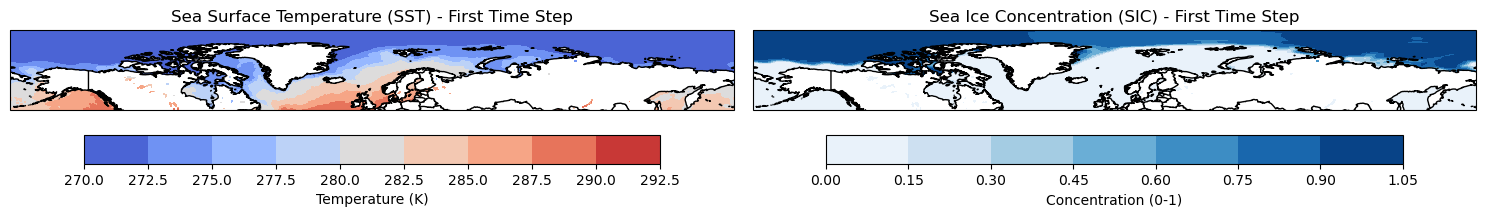

In [5]:
# BEGIN: Plot SST and SIC maps using Cartopy
fig, ax = plt.subplots(1, 2, figsize=(15, 7), subplot_kw={'projection': ccrs.PlateCarree()})  # Adjust the figure size

# Plot SST
ax[0].set_title('Sea Surface Temperature (SST) - First Time Step')
sst_plot = ax[0].contourf(sst.longitude, sst.latitude, sst[0, :, :], transform=ccrs.PlateCarree(), cmap='coolwarm')
ax[0].coastlines()
ax[0].add_feature(cfeature.BORDERS)
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
cbar = fig.colorbar(sst_plot, ax=ax[0], orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label('Temperature (K)')

# Plot SIC
ax[1].set_title('Sea Ice Concentration (SIC) - First Time Step')
sic_plot = ax[1].contourf(sic.longitude, sic.latitude, sic[0, :, :], transform=ccrs.PlateCarree(), cmap='Blues')
ax[1].coastlines()
ax[1].add_feature(cfeature.BORDERS)
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
cbar = fig.colorbar(sic_plot, ax=ax[1], orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label('Concentration (0-1)')

plt.tight_layout()  # Ensure proper spacing
plt.show()
# END: Plot SST and SIC maps using Cartopy

In [6]:
sic.time

<xarray.DataArray 'time' (time: 46)>
array(['1979-09-01T00:00:00.000000000', '1980-09-01T00:00:00.000000000',
       '1981-09-01T00:00:00.000000000', '1982-09-01T00:00:00.000000000',
       '1983-09-01T00:00:00.000000000', '1984-09-01T00:00:00.000000000',
       '1985-09-01T00:00:00.000000000', '1986-09-01T00:00:00.000000000',
       '1987-09-01T00:00:00.000000000', '1988-09-01T00:00:00.000000000',
       '1989-09-01T00:00:00.000000000', '1990-09-01T00:00:00.000000000',
       '1991-09-01T00:00:00.000000000', '1992-09-01T00:00:00.000000000',
       '1993-09-01T00:00:00.000000000', '1994-09-01T00:00:00.000000000',
       '1995-09-01T00:00:00.000000000', '1996-09-01T00:00:00.000000000',
       '1997-09-01T00:00:00.000000000', '1998-09-01T00:00:00.000000000',
       '1999-09-01T00:00:00.000000000', '2000-09-01T00:00:00.000000000',
       '2001-09-01T00:00:00.000000000', '2002-09-01T00:00:00.000000000',
       '2003-09-01T00:00:00.000000000', '2004-09-01T00:00:00.000000000',
       '2005-09-01T00:00:00.000000000', '2006-09-01T00:00:00.000000000',
       '2007-09-01T00:00:00.000000000', '2008-09-01T00:00:00.000000000',
       '2009-09-01T00:00:00.000000000', '2010-09-01T00:00:00.000000000',
       '2011-09-01T00:00:00.000000000', '2012-09-01T00:00:00.000000000',
       '2013-09-01T00:00:00.000000000', '2014-09-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2016-09-01T00:00:00.000000000',
       '2017-09-01T00:00:00.000000000', '2018-09-01T00:00:00.000000000',
       '2019-09-01T00:00:00.000000000', '2020-09-01T00:00:00.000000000',
       '2021-09-01T00:00:00.000000000', '2022-09-01T00:00:00.000000000',
       '2023-09-01T00:00:00.000000000', '2024-09-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-09-01 1980-09-01 ... 2024-09-01

In [7]:
# Filter SST data to include only dates with '09' in the month (September)
sst_september = sst.sel(time=sst.time.astype(str).str[5:7] == '09')
sst_september

<xarray.DataArray 'sst' (time: 46, latitude: 160, longitude: 1440)>
[10598400 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1979-09-01 1980-09-01 ... 2024-09-01
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... 50.75 50.5 50.25
  * longitude  (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
Attributes: (12/32)
    GRIB_paramId:                             34
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      404640
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_units:                               K
    long_name:                                Sea surface temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0
    coordinates:                              number date latitude longitude ...

In [8]:
sst = sst_september.fillna(0) # JUst in case

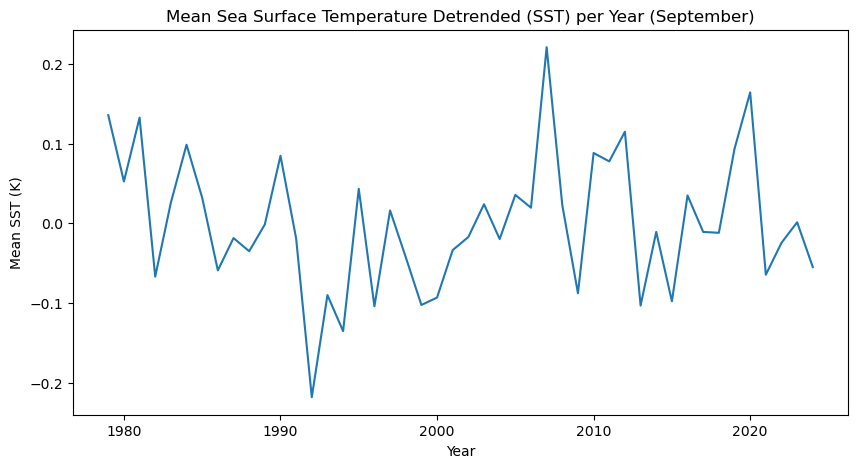

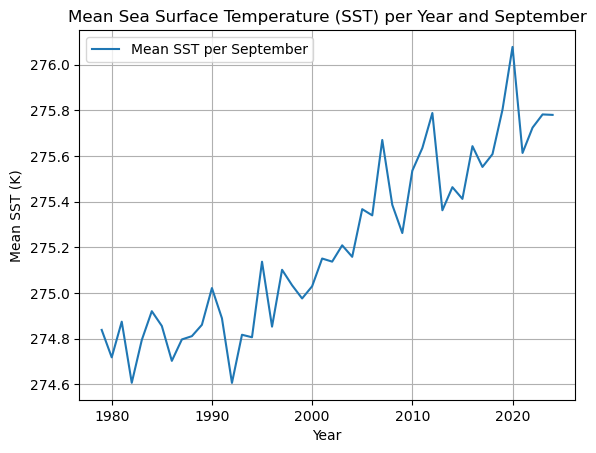

In [9]:
# Detrend SST
import scipy.signal as sig
sst_detrended = sig.detrend(sst, axis=0)

# Plot mean SST per year from 1979 until 2023
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1979, 2024 + 1, 1), np.mean(np.mean(sst_detrended, axis=(1)), axis=(1)), label='Mean SST per Year')
plt.xlabel('Year')
plt.ylabel('Mean SST (K)')
plt.title('Mean Sea Surface Temperature Detrended (SST) per Year (September)')
plt.show()
plt.plot(np.arange(1979, 2024 + 1, 1), np.mean(np.mean(sst_september, axis=(1)), axis=(1)), label='Mean SST per September')
plt.xlabel('Year')
plt.ylabel('Mean SST (K)')
plt.title('Mean Sea Surface Temperature (SST) per Year and September')
plt.legend()
plt.grid(True)
plt.show()

(46, 230400)


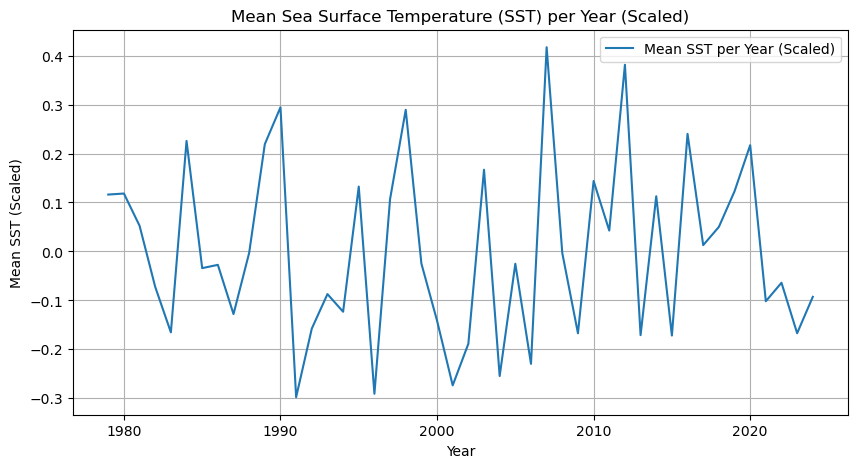

In [10]:
# Using Scalar, since we already found anomalies by detrending, we are effictlvey just dividng by standard deviation  since are values are already oreitnated around 0
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # Remove move and nomralize by std
sst_detrended_reshaped = sst_detrended.reshape(sst_detrended.shape[0], -1)
print(sst_detrended_reshaped.shape)
sst_scaled = scaler.fit_transform(sst_detrended_reshaped).reshape(sst_detrended.shape)
# Plot mean SST per year from 1979 until 2024 for scaled data
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1979, 2024 + 1, 1), np.mean(np.mean(sst_scaled, axis=(1)), axis=1), label='Mean SST per Year (Scaled)')
plt.xlabel('Year')
plt.ylabel('Mean SST (Scaled)')
plt.title('Mean Sea Surface Temperature (SST) per Year (Scaled)')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Now we do PCA analaysis - EOF time!
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
sst_scaled=sst_scaled.reshape(sst_scaled.shape[0],-1)
principal_components = pca.fit_transform(sst_scaled)

Explained Variance Ratios: [0.21811208 0.10283007 0.08517405 0.07974775 0.06217627]


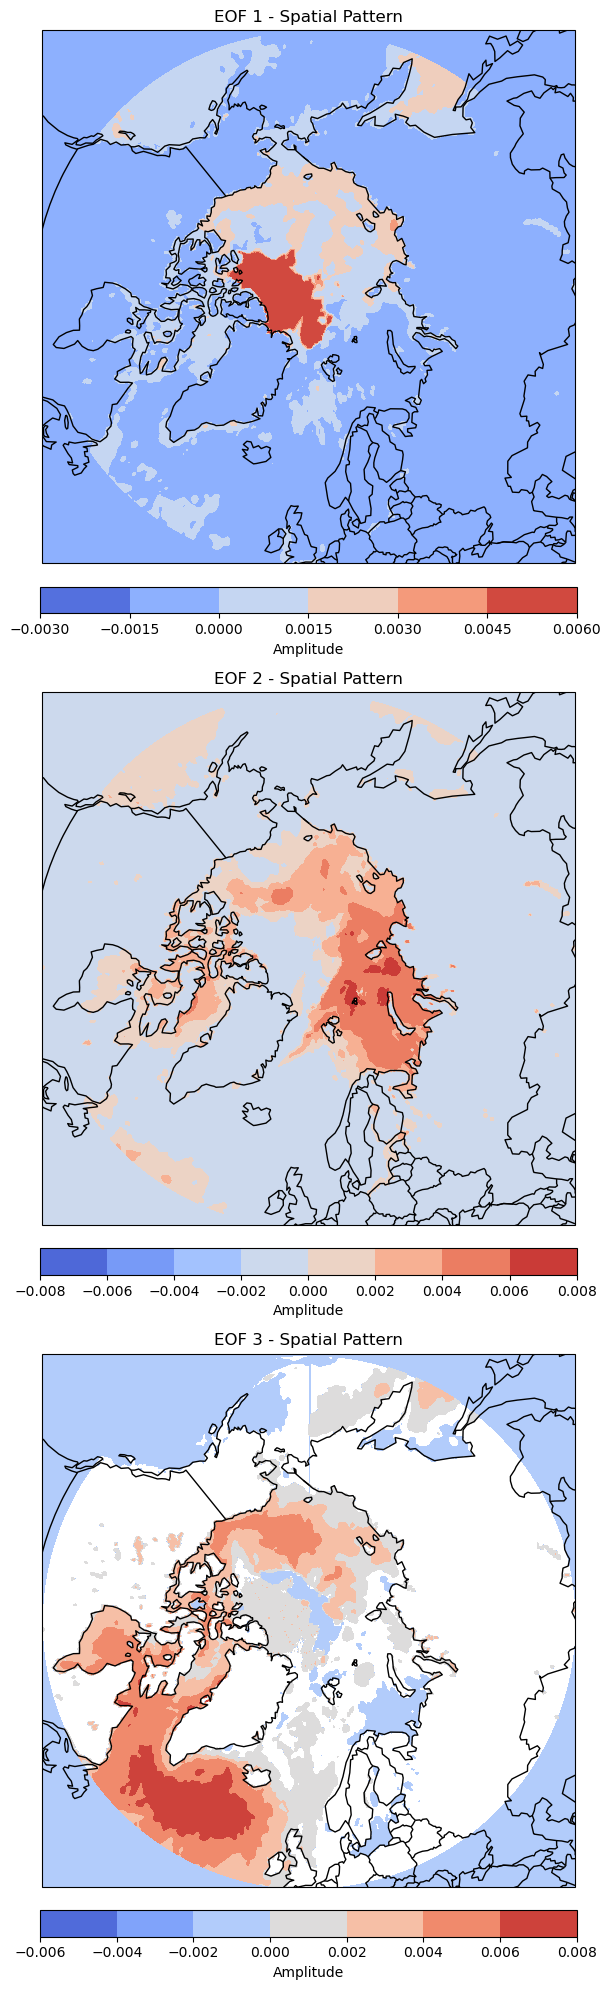

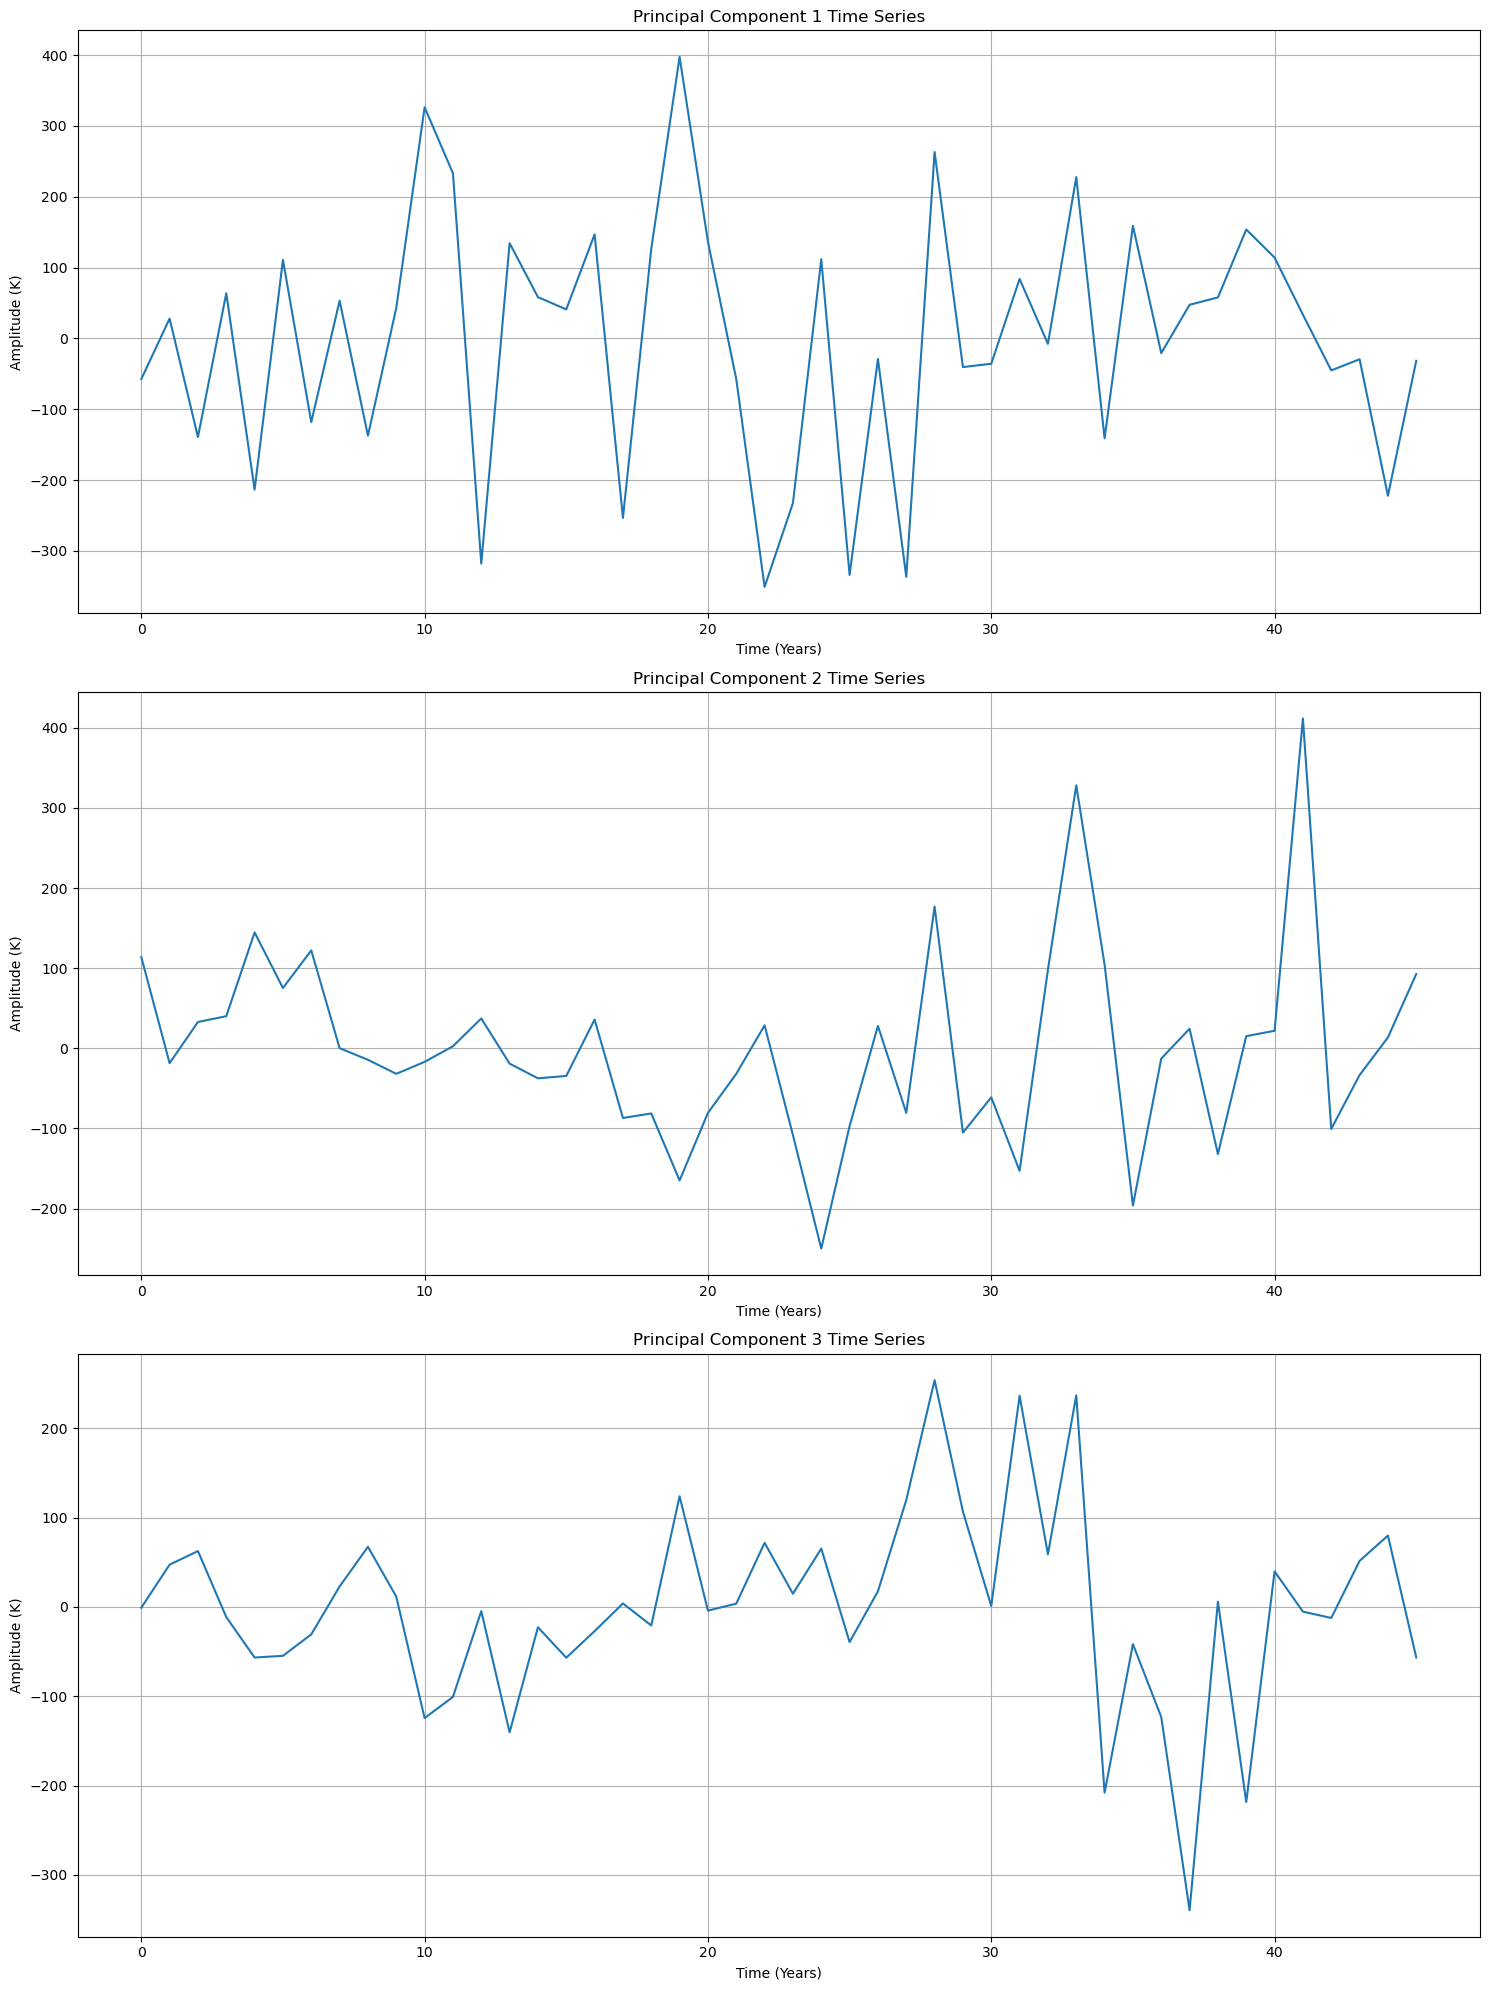

In [12]:
# Now set up the first five EOFs
eofs = pca.components_.reshape(5, len(sst_september.latitude), len(sst_september.longitude))
# Explained variance ratios
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratios:", explained_variance)
# BEGIN: Plot the first five EOFs with north pole projection
fig, axes = plt.subplots(3, 1, figsize=(15, 20), subplot_kw={'projection': ccrs.NorthPolarStereo()})
axes = axes.flatten()

for i in range(3):
    ax = axes[i]
    ax.set_title(f'EOF {i+1} - Spatial Pattern')
    eof_plot = ax.contourf(sst_september.longitude, sst_september.latitude, eofs[i], transform=ccrs.PlateCarree(), cmap='coolwarm')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
    cbar = fig.colorbar(eof_plot, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
    cbar.set_label('Amplitude')

plt.tight_layout()
plt.show()
# END: Plot the first five EOFs with north pole projection
# Plot the corresponding time series of the first five principal components
fig, axes = plt.subplots(3, 1, figsize=(15, 20))

for i in range(3):
    ax = axes[i]
    ax.plot(principal_components[:, i])
    ax.set_title(f'Principal Component {i+1} Time Series')
    ax.set_xlabel('Time (Years)')
    ax.set_ylabel('Amplitude (K)')
    ax.grid(True)

plt.tight_layout()
plt.show()

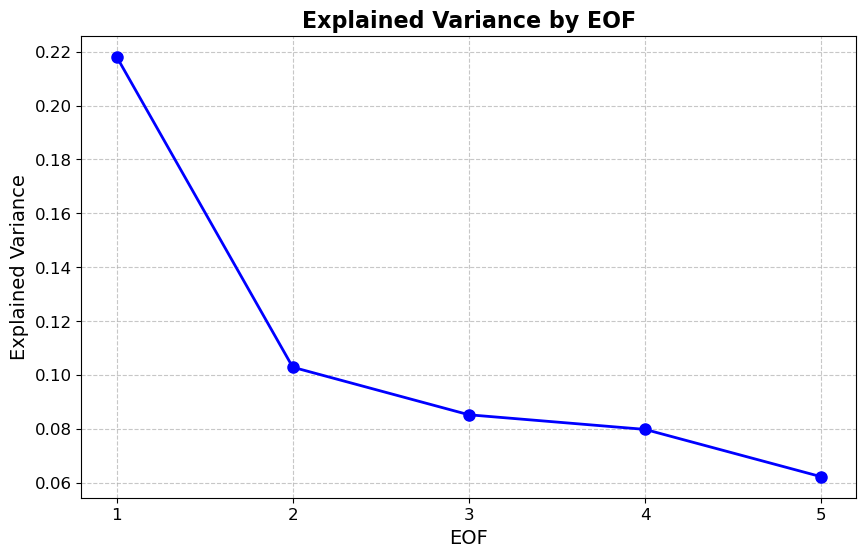

In [13]:
# Output explained variance by EOF with enhanced visualization
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 6, 1), explained_variance, marker='o', linestyle='-', color='b', markersize=8, linewidth=2)
#plt.fill_between(np.arange(1, 6, 1), explained_variance, color='skyblue', alpha=0.4)
plt.xticks(np.arange(1, 6, 1), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('EOF', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Explained Variance by EOF', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Importantly here, the first EOF explains most of the variance. E.g. most of the variance in the SST is caused by the sea ice... which makes sense. We should probably clip our data so to only be deep in the ice pack. Let's see how SST varies in the ice pack. It is also important to note that the first EOF is well understood, and is caused by the sea ice (water can only be so cold before it freezes). Also, note how the amount of varience explained is quite low. This is because we have a large area over the northern hemisphere. Let us try again, but with the data for only the most northern of coordinates.

In [14]:
sst_september.latitude

<xarray.DataArray 'latitude' (latitude: 160)>
array([90.  , 89.75, 89.5 , 89.25, 89.  , 88.75, 88.5 , 88.25, 88.  , 87.75,
       87.5 , 87.25, 87.  , 86.75, 86.5 , 86.25, 86.  , 85.75, 85.5 , 85.25,
       85.  , 84.75, 84.5 , 84.25, 84.  , 83.75, 83.5 , 83.25, 83.  , 82.75,
       82.5 , 82.25, 82.  , 81.75, 81.5 , 81.25, 81.  , 80.75, 80.5 , 80.25,
       80.  , 79.75, 79.5 , 79.25, 79.  , 78.75, 78.5 , 78.25, 78.  , 77.75,
       77.5 , 77.25, 77.  , 76.75, 76.5 , 76.25, 76.  , 75.75, 75.5 , 75.25,
       75.  , 74.75, 74.5 , 74.25, 74.  , 73.75, 73.5 , 73.25, 73.  , 72.75,
       72.5 , 72.25, 72.  , 71.75, 71.5 , 71.25, 71.  , 70.75, 70.5 , 70.25,
       70.  , 69.75, 69.5 , 69.25, 69.  , 68.75, 68.5 , 68.25, 68.  , 67.75,
       67.5 , 67.25, 67.  , 66.75, 66.5 , 66.25, 66.  , 65.75, 65.5 , 65.25,
       65.  , 64.75, 64.5 , 64.25, 64.  , 63.75, 63.5 , 63.25, 63.  , 62.75,
       62.5 , 62.25, 62.  , 61.75, 61.5 , 61.25, 61.  , 60.75, 60.5 , 60.25,
       60.  , 59.75, 59.5 , 59.25, 59.  , 58.75, 58.5 , 58.25, 58.  , 57.75,
       57.5 , 57.25, 57.  , 56.75, 56.5 , 56.25, 56.  , 55.75, 55.5 , 55.25,
       55.  , 54.75, 54.5 , 54.25, 54.  , 53.75, 53.5 , 53.25, 53.  , 52.75,
       52.5 , 52.25, 52.  , 51.75, 51.5 , 51.25, 51.  , 50.75, 50.5 , 50.25])
Coordinates:
  * latitude  (latitude) float64 90.0 89.75 89.5 89.25 ... 51.0 50.75 50.5 50.25
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing

(46, 80, 1440)
(46, 115200)


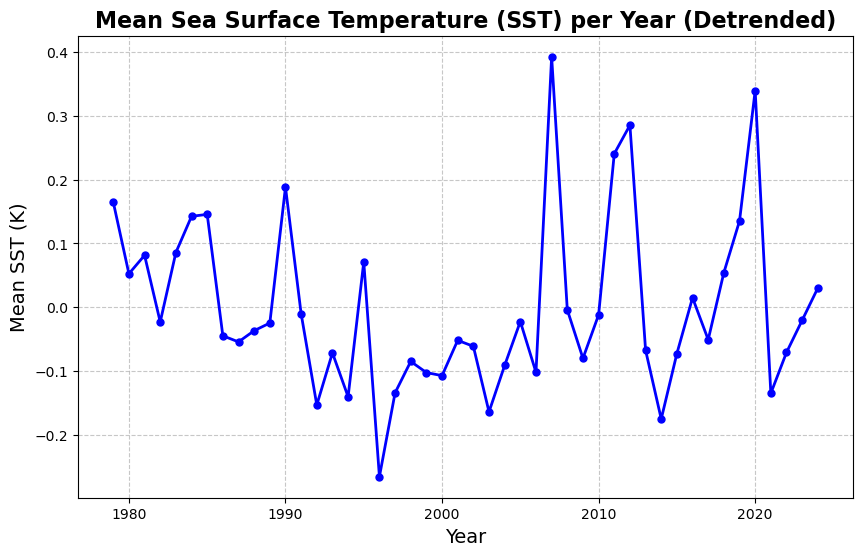

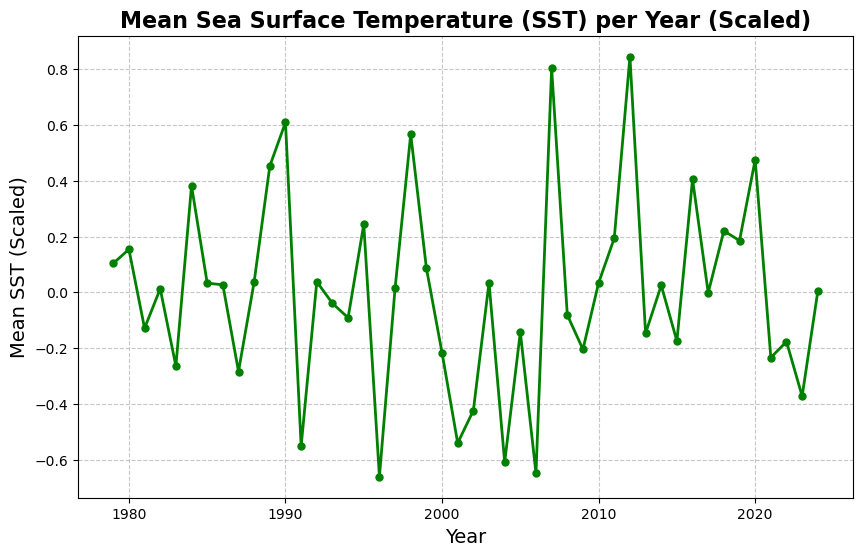

In [15]:
sst_trim = sst_september.fillna(0)
sst_trim=sst_trim.isel(latitude=slice(0, 80)) # Just in the ice pack - very far north up from 70N
sst_trim=sst_trim.values
print(sst_trim.shape)
#Reshape to 45, 161*1440
sst_trim=sst_trim.reshape(46, 80*1440)
print(sst_trim.shape)
# Detrend SST
import scipy.signal as sig
sst_trim = sig.detrend(sst_trim, axis=0)

# Plot mean SST per year from 1979 until 2023 with enhanced visualization
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1979, 2024 + 1, 1), np.mean(sst_trim, axis=(1)), marker='o', linestyle='-', color='b', markersize=5, linewidth=2)
#plt.fill_between(np.arange(1979, 2024 + 1, 1), np.mean(sst_trim, axis=(1)), color='skyblue', alpha=0.4)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean SST (K)', fontsize=14)
plt.title('Mean Sea Surface Temperature (SST) per Year (Detrended)', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Using Scalar, since we already found anomalies by detrending, we are effectively just dividing by standard deviation since our values are already oriented around 0
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  # Remove mean and normalize by std
sst_trim = scaler.fit_transform(sst_trim)

# Plot mean SST per year from 1979 until 2023 for scaled data with enhanced visualization
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1979, 2024 + 1, 1), np.mean(sst_trim, axis=(1)), marker='o', linestyle='-', color='g', markersize=5, linewidth=2)
#plt.fill_between(np.arange(1979, 2024 + 1, 1), np.mean(sst_trim, axis=(1)), color='lightgreen', alpha=0.4)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean SST (Scaled)', fontsize=14)
plt.title('Mean Sea Surface Temperature (SST) per Year (Scaled)', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
                       

Explained Variance Ratios (Trimmed SST): [0.30600467 0.12252796 0.09491213 0.08120295 0.05322971]


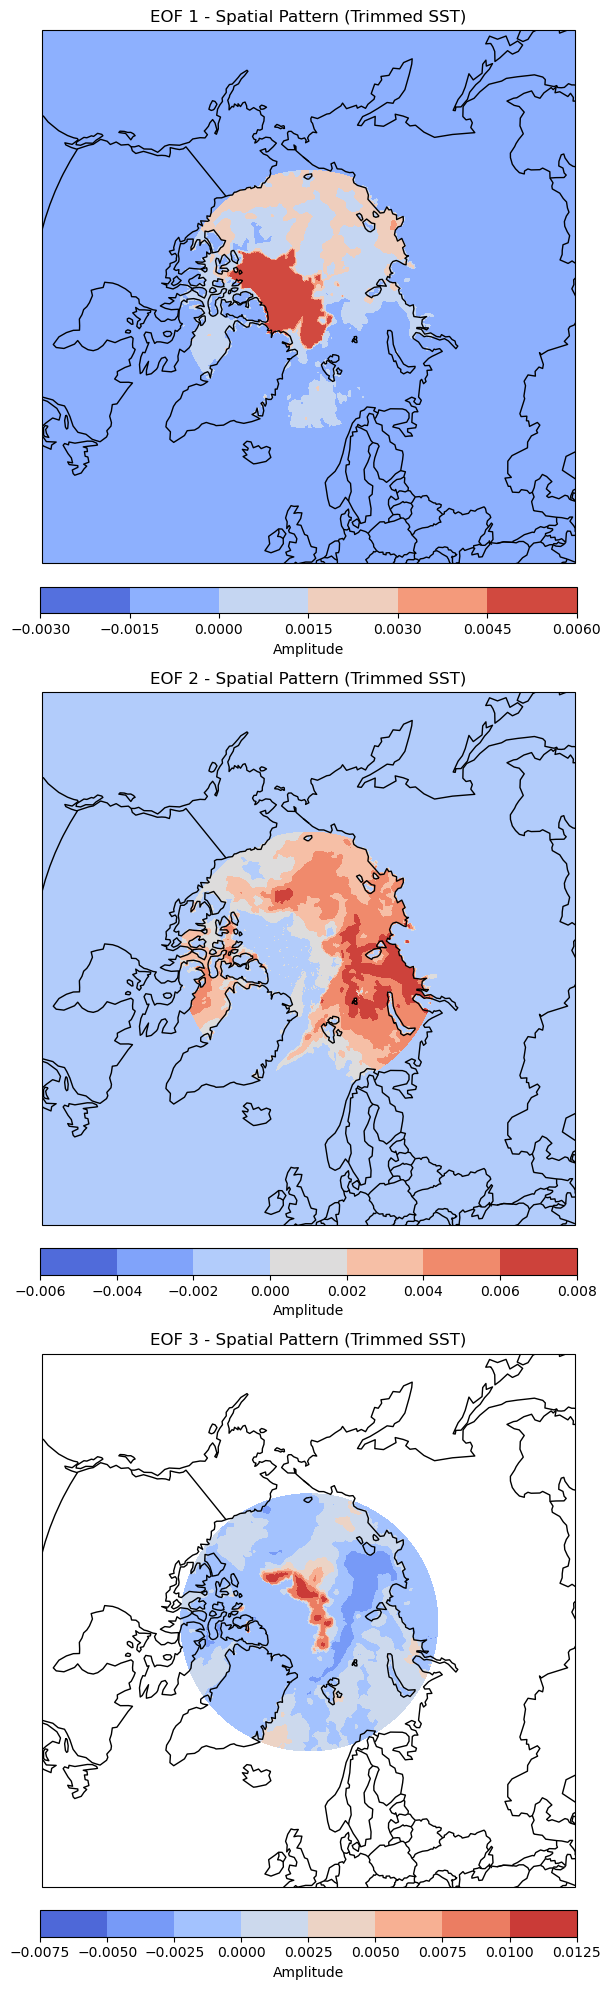

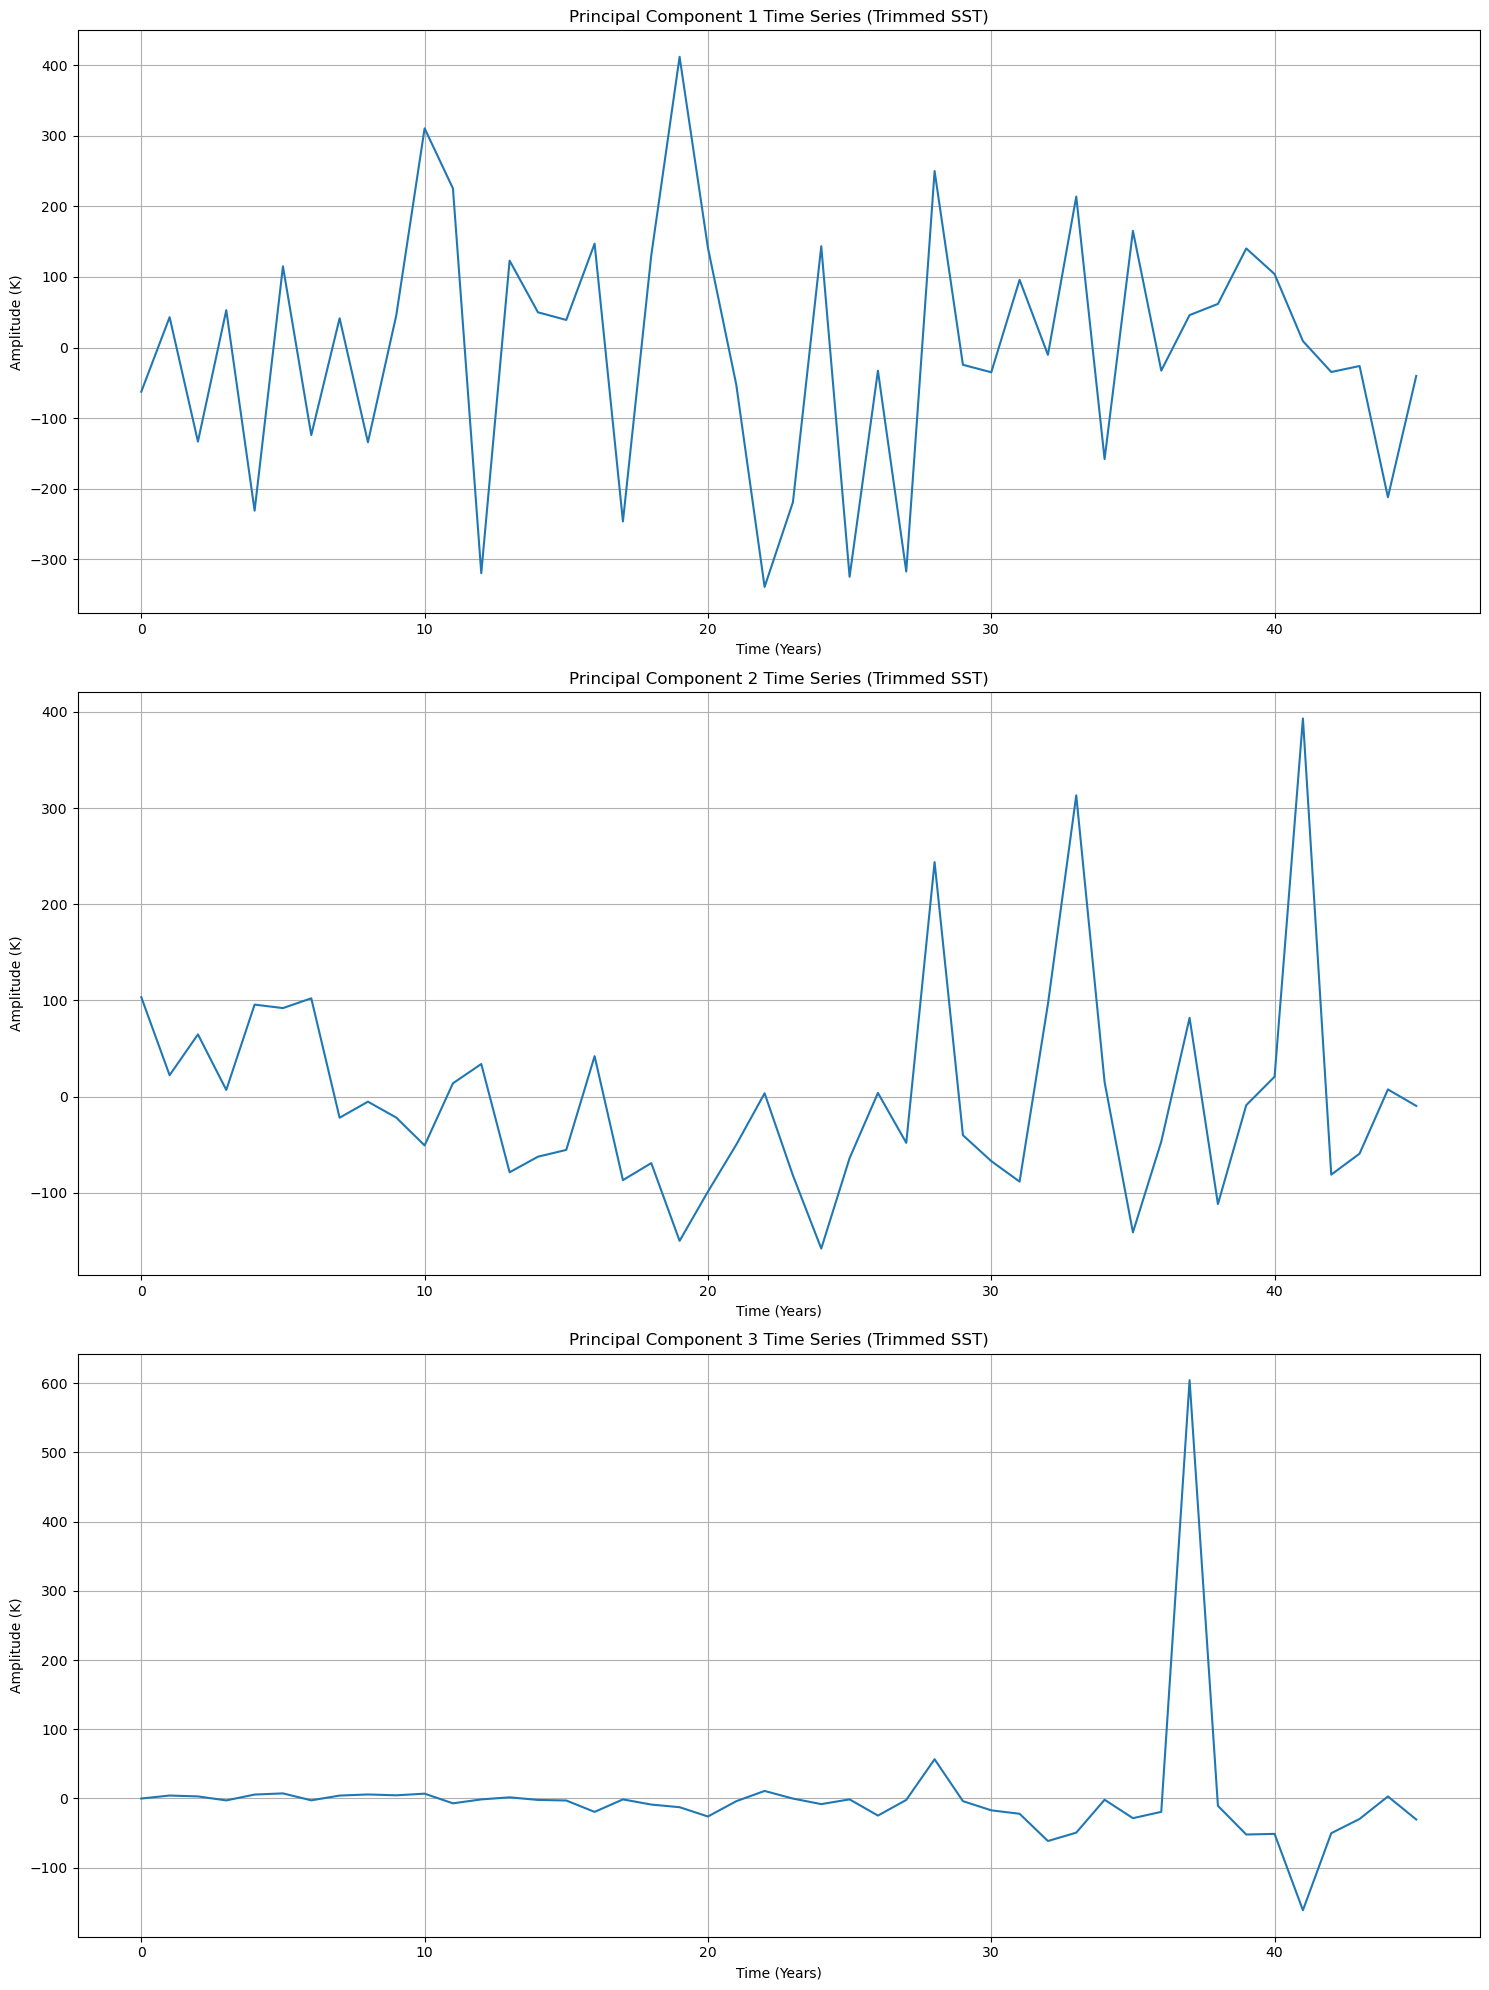

In [16]:
# Now we do PCA analysis for trimmed SST data - EOF time!
pca_trim = PCA(n_components=5)
principal_components_trim = pca_trim.fit_transform(sst_trim)

# Now set up the first five EOFs for trimmed SST
eofs_trim = pca_trim.components_.reshape(5, 80, len(sst_september.longitude))

# Explained variance ratios for trimmed SST
explained_variance_trim = pca_trim.explained_variance_ratio_
print("Explained Variance Ratios (Trimmed SST):", explained_variance_trim)

# Plot the first three EOFs with north pole projection for trimmed SST
fig, axes = plt.subplots(3, 1, figsize=(15, 20), subplot_kw={'projection': ccrs.NorthPolarStereo()})
axes = axes.flatten()

for i in range(3):
    ax = axes[i]
    ax.set_title(f'EOF {i+1} - Spatial Pattern (Trimmed SST)')
    eof_plot = ax.contourf(sst_september.longitude, sst_september.latitude[:80], eofs_trim[i], transform=ccrs.PlateCarree(), cmap='coolwarm')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
    cbar = fig.colorbar(eof_plot, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
    cbar.set_label('Amplitude')

plt.tight_layout()
plt.show()

# Plot the corresponding time series of the first three principal components for trimmed SST
fig, axes = plt.subplots(3, 1, figsize=(15, 20))

for i in range(3):
    ax = axes[i]
    ax.plot(principal_components_trim[:, i])
    ax.set_title(f'Principal Component {i+1} Time Series (Trimmed SST)')
    ax.set_xlabel('Time (Years)')
    ax.set_ylabel('Amplitude (K)')
    ax.grid(True)

plt.tight_layout()
plt.show()

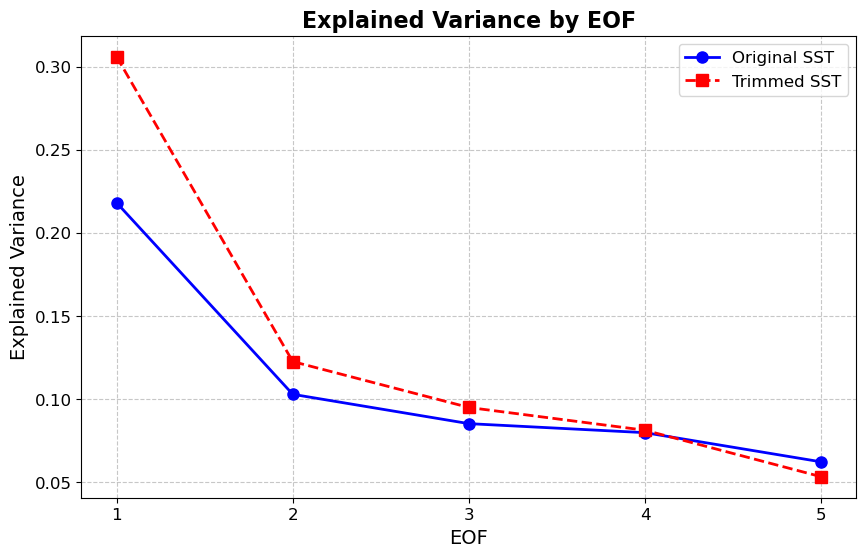

In [17]:
# Plot explained variance with enhanced visualization
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 6, 1), explained_variance, marker='o', linestyle='-', color='b', markersize=8, linewidth=2, label='Original SST')
plt.plot(np.arange(1, 6, 1), explained_variance_trim, marker='s', linestyle='--', color='r', markersize=8, linewidth=2, label='Trimmed SST')
#plt.fill_between(np.arange(1, 6, 1), explained_variance, color='skyblue', alpha=0.4)
#plt.fill_between(np.arange(1, 6, 1), explained_variance_trim, color='lightcoral', alpha=0.4)
plt.xticks(np.arange(1, 6, 1), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('EOF', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Explained Variance by EOF', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Now, let's see what SIC looks like

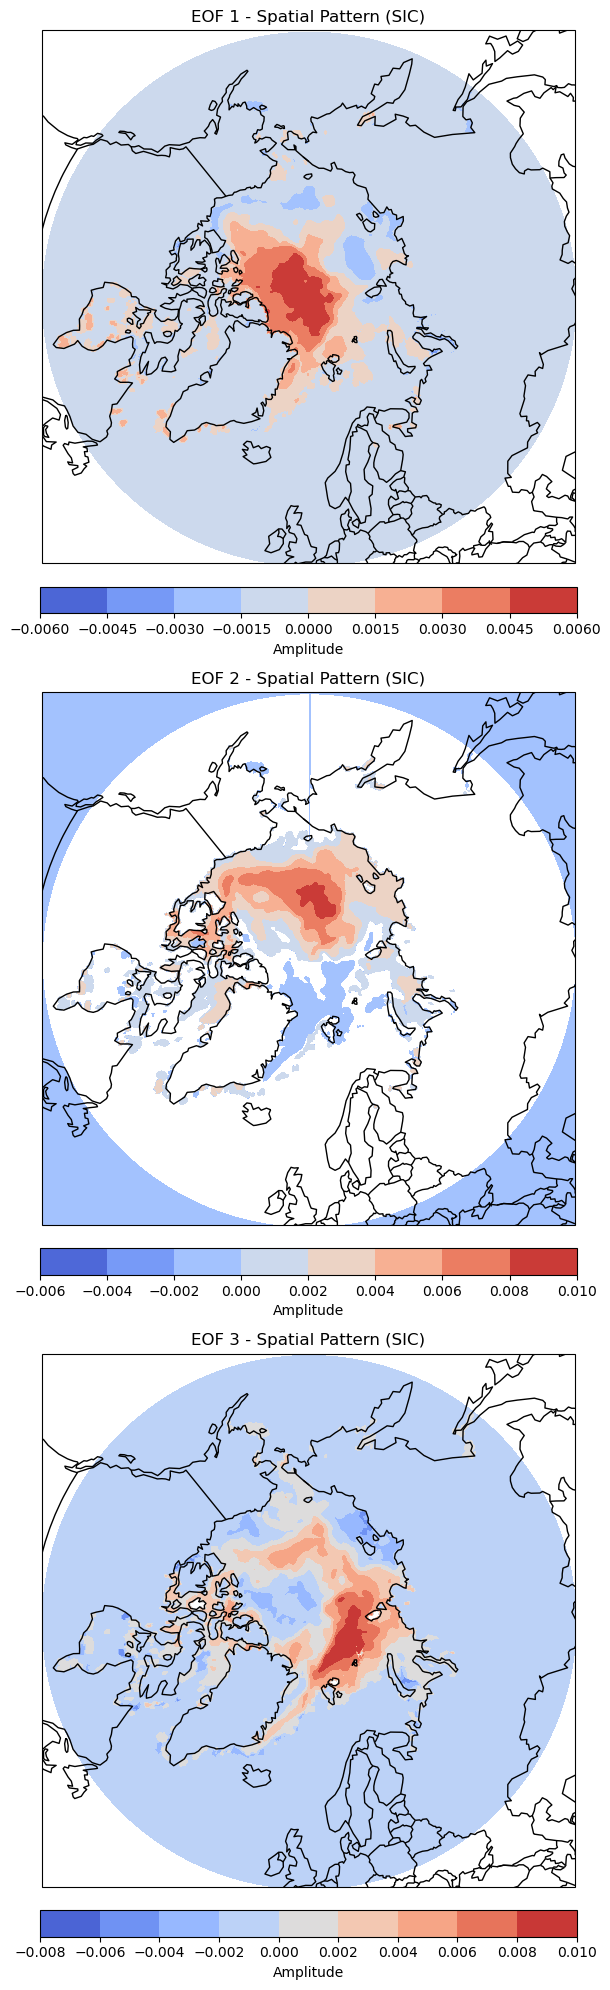

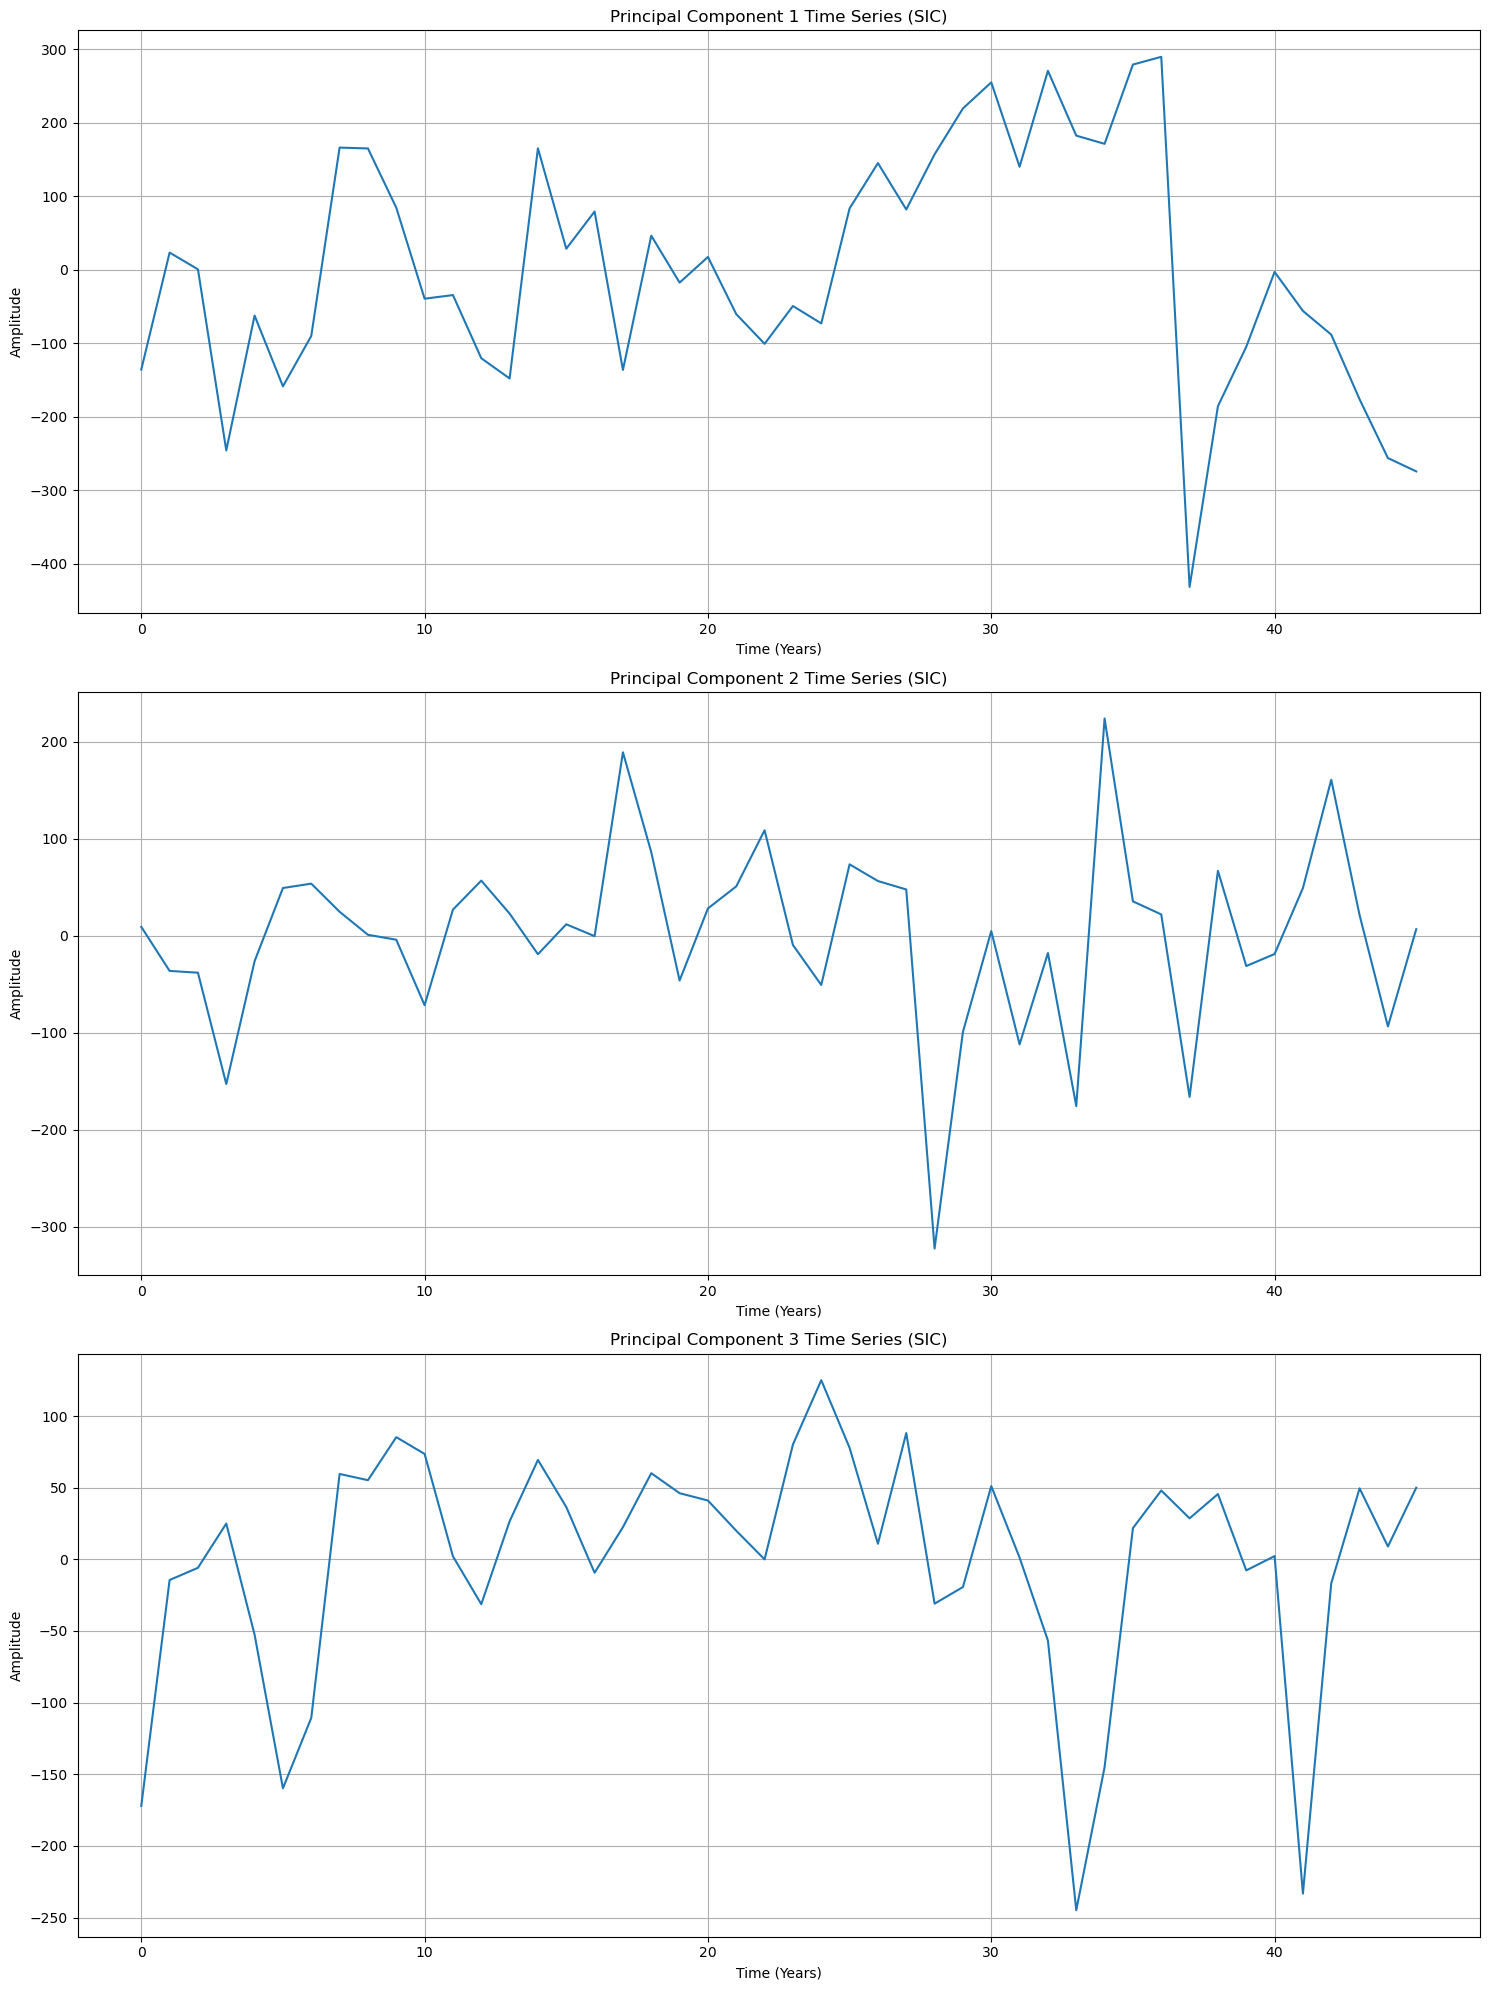

In [18]:
sic = sic.fillna(0)
# Detrend SIC
sic_detrended = sig.detrend(sic, axis=0)

# Normalize SIC
sic_scaled = scaler.fit_transform(sic_detrended.reshape(sic_detrended.shape[0], -1)).reshape(sic_detrended.shape)

# Perform PCA on SIC
pca_sic = PCA(n_components=5)
principal_components_sic = pca_sic.fit_transform(sic_scaled.reshape(sic_scaled.shape[0], -1))

# Set up the first five EOFs for SIC
eofs_sic = pca_sic.components_.reshape(5, len(sst_september.latitude), len(sst_september.longitude))

# Plot the first three EOFs with north pole projection for SIC
fig, axes = plt.subplots(3, 1, figsize=(15, 20), subplot_kw={'projection': ccrs.NorthPolarStereo()})
axes = axes.flatten()

for i in range(3):
    ax = axes[i]
    ax.set_title(f'EOF {i+1} - Spatial Pattern (SIC)')
    eof_plot = ax.contourf(sst_september.longitude, sst_september.latitude, eofs_sic[i], transform=ccrs.PlateCarree(), cmap='coolwarm')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
    cbar = fig.colorbar(eof_plot, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
    cbar.set_label('Amplitude')

plt.tight_layout()
plt.show()

# Plot the corresponding time series of the first three principal components for SIC
fig, axes = plt.subplots(3, 1, figsize=(15, 20))

for i in range(3):
    ax = axes[i]
    ax.plot(principal_components_sic[:, i])
    ax.set_title(f'Principal Component {i+1} Time Series (SIC)')
    ax.set_xlabel('Time (Years)')
    ax.set_ylabel('Amplitude')
    ax.grid(True)

plt.tight_layout()
plt.show()

Explained Variance Ratios (SIC): [0.27510652 0.09122357 0.06789389 0.04944159 0.03830028]


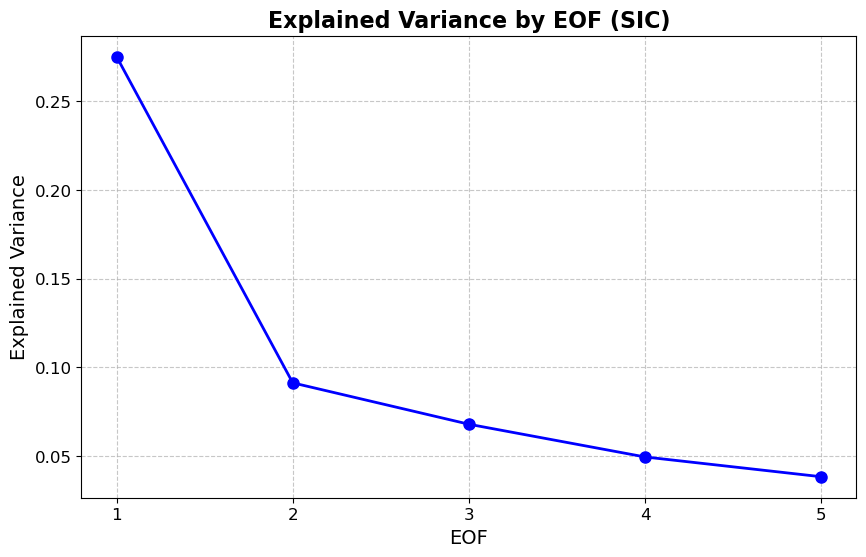

In [19]:
# Calculate explained variance for SIC
explained_variance_sic = pca_sic.explained_variance_ratio_
print("Explained Variance Ratios (SIC):", explained_variance_sic)

# Output explained variance by EOF for SIC with enhanced visualization
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 6, 1), explained_variance_sic, marker='o', linestyle='-', color='b', markersize=8, linewidth=2)
#plt.fill_between(np.arange(1, 6, 1), explained_variance_sic, color='skyblue', alpha=0.4)
plt.xticks(np.arange(1, 6, 1), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('EOF', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Explained Variance by EOF (SIC)', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [20]:
sic_trim=sic
# Setting sic values to 0 if nan
sic_trim = sic_trim.fillna(0)
sic_trim=sic_trim.isel(latitude=slice(0, 80))
sic_trim=sic_trim.values
print(sic_trim.shape)
# Redhaping to 2D
sic_trim = sic_trim.reshape(46, 80*1440)
print(sic_trim.shape)

(46, 80, 1440)
(46, 115200)


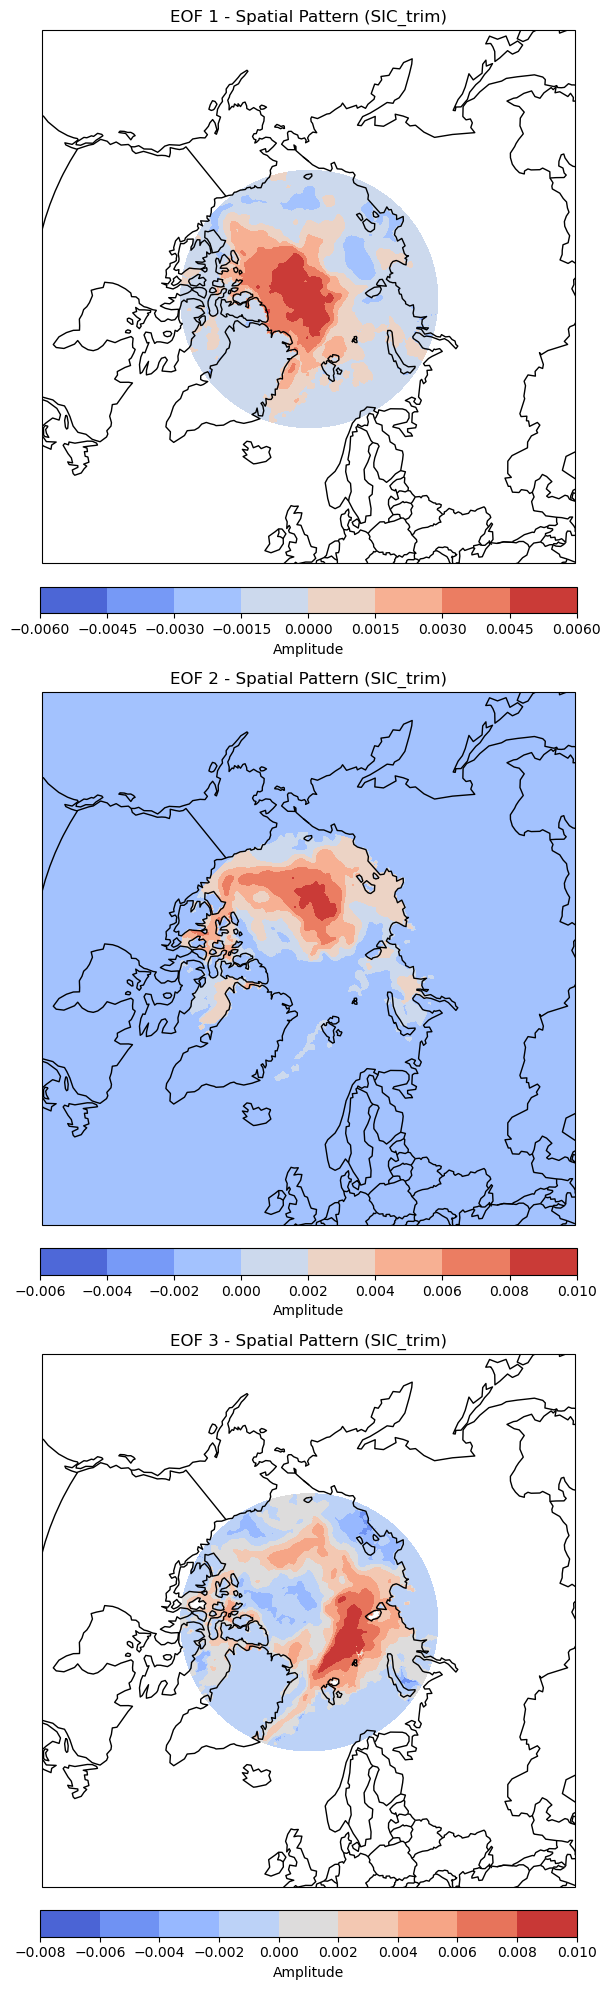

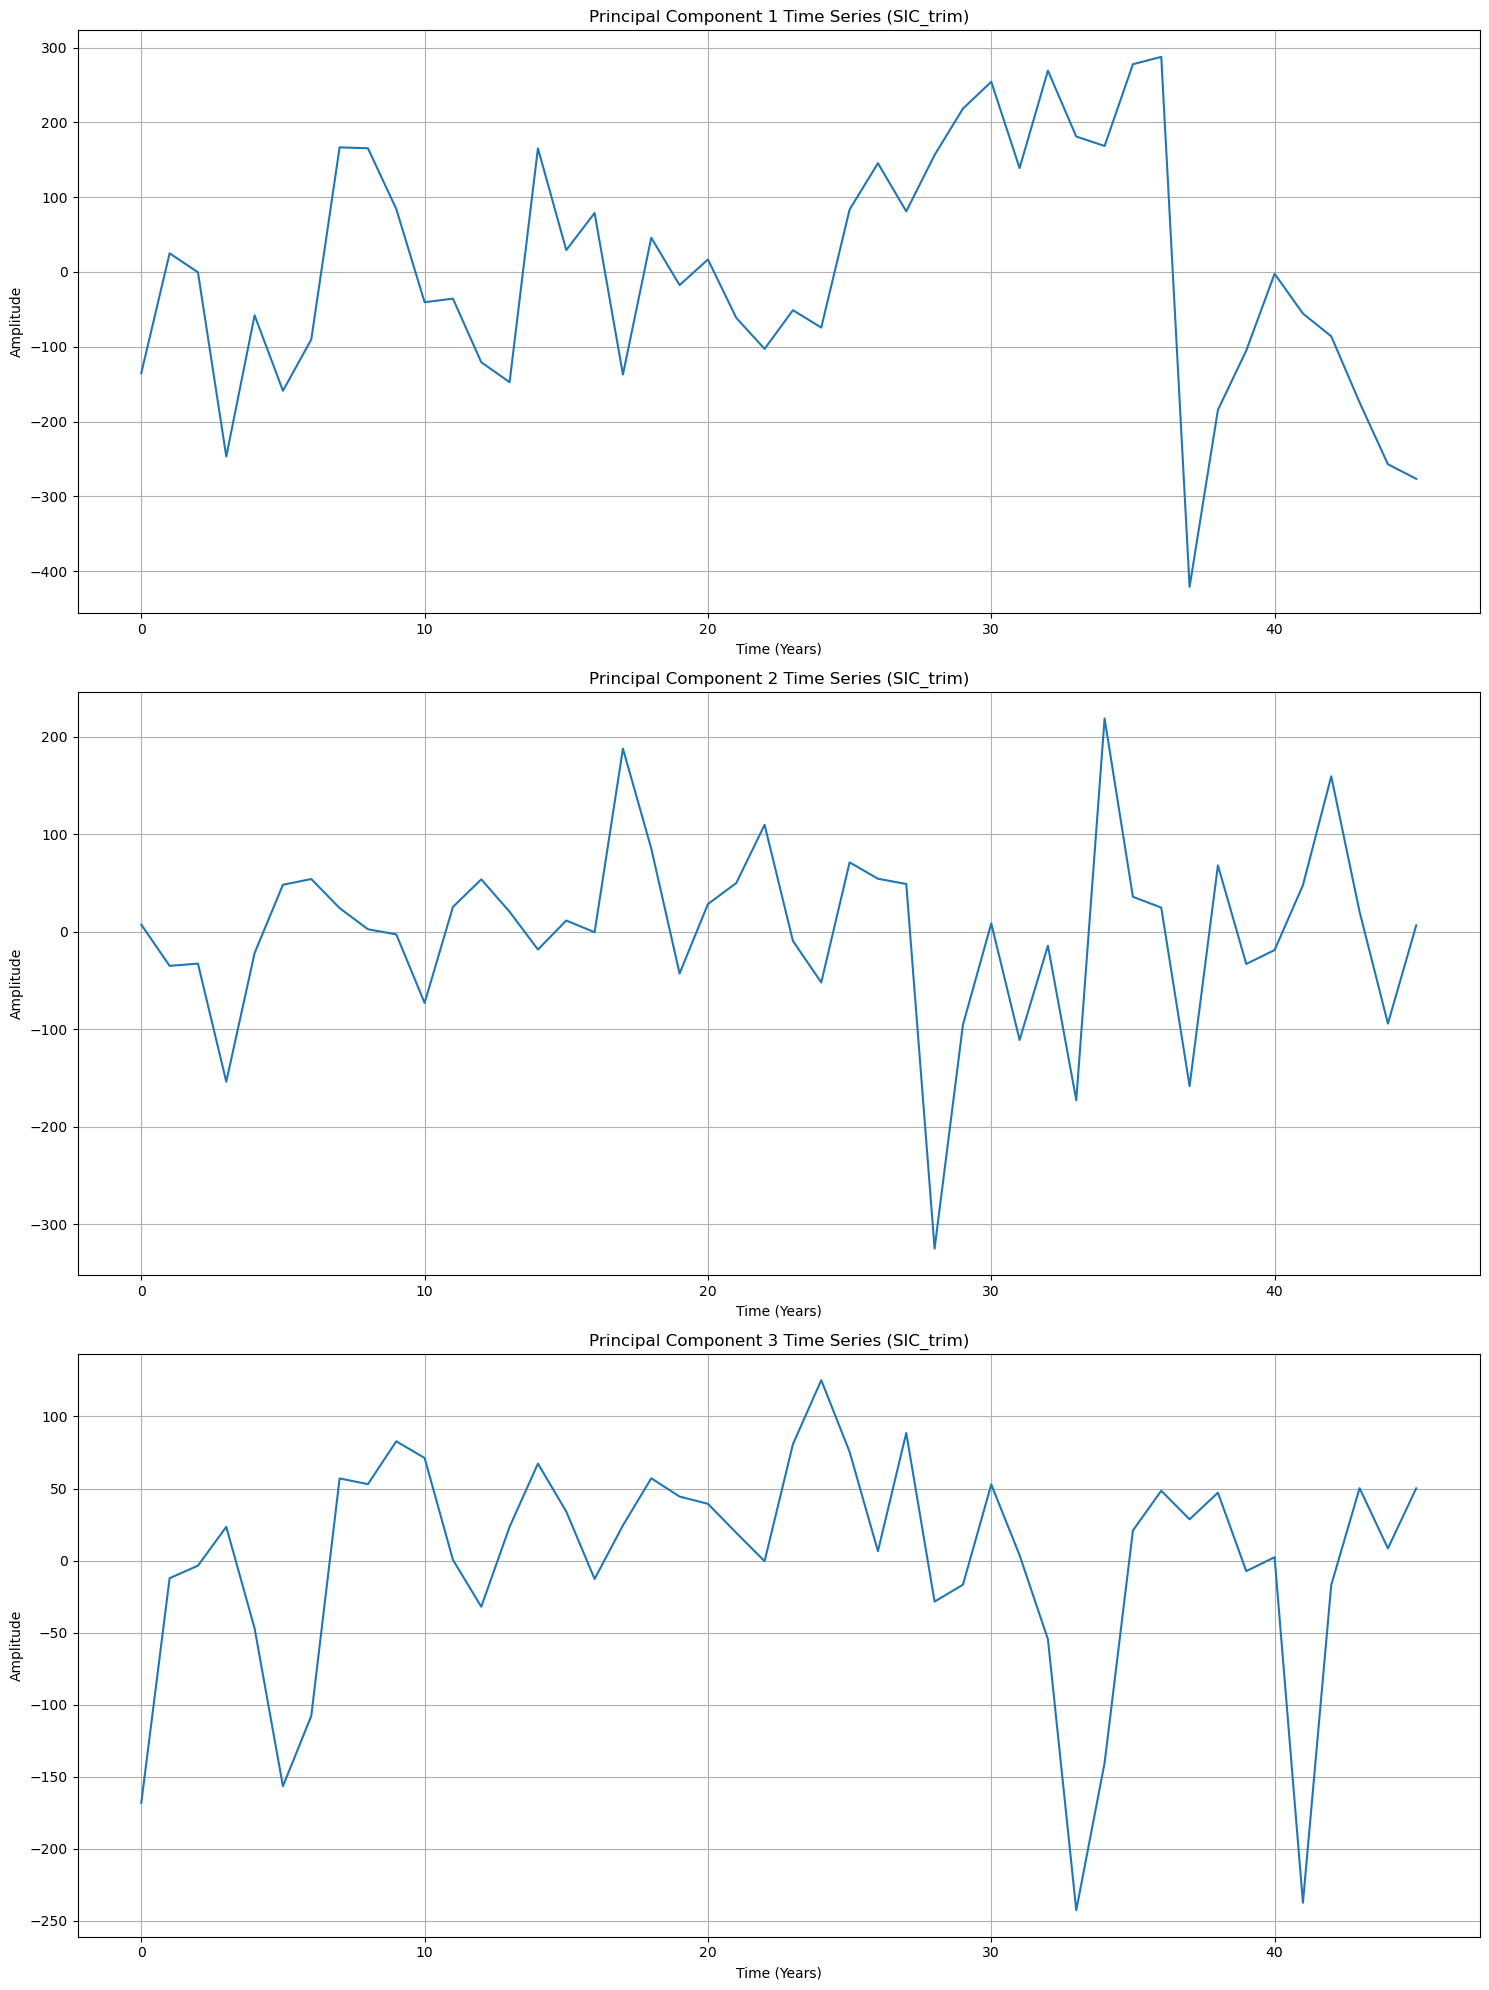

Explained Variance Ratios (SIC_trim): [0.29102945 0.09575026 0.07107937 0.05092451 0.03976309]


In [21]:
# Detrend SIC_trim
sic_trim_detrended = sig.detrend(sic_trim, axis=0)

# Normalize SIC_trim
sic_trim_scaled = scaler.fit_transform(sic_trim_detrended.reshape(sic_trim_detrended.shape[0], -1)).reshape(sic_trim_detrended.shape)

# Perform PCA on SIC_trim
pca_sic_trim = PCA(n_components=5)
principal_components_sic_trim = pca_sic_trim.fit_transform(sic_trim_scaled.reshape(sic_trim_scaled.shape[0], -1))

# Set up the first five EOFs for SIC_trim
eofs_sic_trim = pca_sic_trim.components_.reshape(5, 80, len(sst_september.longitude))

# Plot the first three EOFs with north pole projection for SIC_trim
fig, axes = plt.subplots(3, 1, figsize=(15, 20), subplot_kw={'projection': ccrs.NorthPolarStereo()})
axes = axes.flatten()

for i in range(3):
    ax = axes[i]
    ax.set_title(f'EOF {i+1} - Spatial Pattern (SIC_trim)')
    eof_plot = ax.contourf(sst_september.longitude, sst_september.latitude[:80], eofs_sic_trim[i], transform=ccrs.PlateCarree(), cmap='coolwarm')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
    cbar = fig.colorbar(eof_plot, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
    cbar.set_label('Amplitude')

plt.tight_layout()
plt.show()

# Plot the corresponding time series of the first three principal components for SIC_trim
fig, axes = plt.subplots(3, 1, figsize=(15, 20))

for i in range(3):
    ax = axes[i]
    ax.plot(principal_components_sic_trim[:, i])
    ax.set_title(f'Principal Component {i+1} Time Series (SIC_trim)')
    ax.set_xlabel('Time (Years)')
    ax.set_ylabel('Amplitude')
    ax.grid(True)

plt.tight_layout()
plt.show()

# Explained variance ratios for SIC_trim
explained_variance_sic_trim = pca_sic_trim.explained_variance_ratio_
print("Explained Variance Ratios (SIC_trim):", explained_variance_sic_trim)

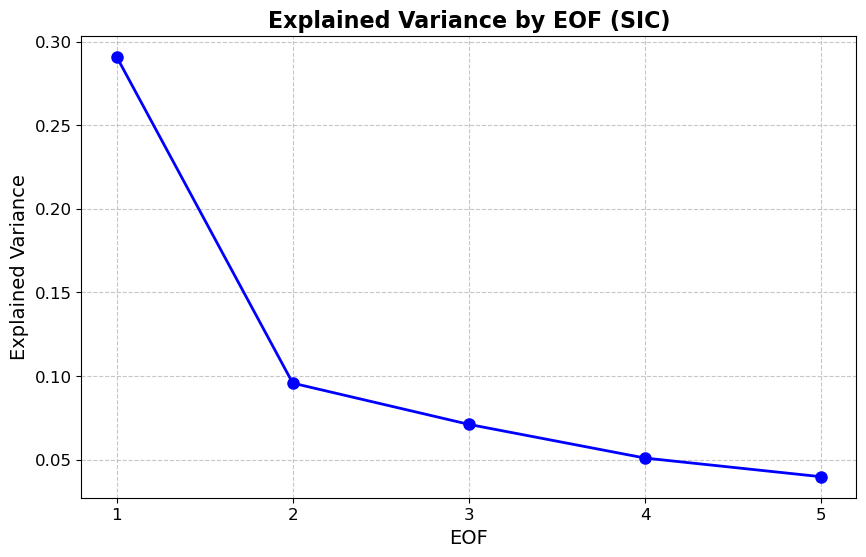

In [22]:
# Output explained variance by EOF for SIC with enhanced visualization
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 6, 1), explained_variance_sic_trim, marker='o', linestyle='-', color='b', markersize=8, linewidth=2)
plt.xticks(np.arange(1, 6, 1), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('EOF', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Explained Variance by EOF (SIC)', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

6.259674e-07


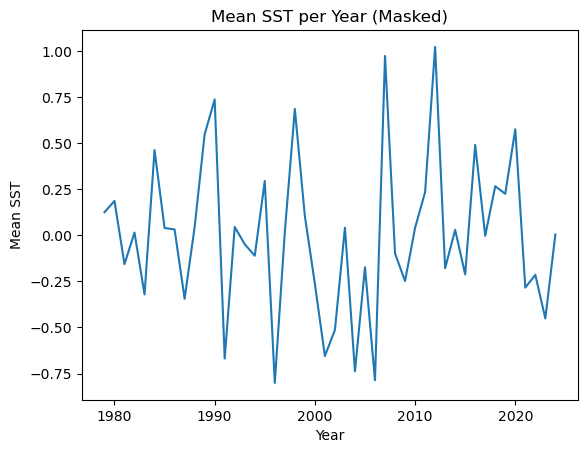

In [23]:
# Mask 0s in sst_trim
sst_trim_masked = np.ma.masked_equal(sst_trim, 0)
print(np.min(abs(sst_trim_masked))) # No zeros left
# Plot mean SST per year from 1979 until 2024 for masked data
plt.plot(np.arange(1979, 2024 + 1, 1), np.mean(sst_trim_masked, axis=(1)))
plt.title('Mean SST per Year (Masked)')
plt.xlabel('Year')
plt.ylabel('Mean SST')
plt.show()

In [24]:
# Now do t-Distributed Stochastic Neighbor Embedding (t-SNE) for SST
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
sst_tsne = tsne.fit_transform(sst_trim_masked)
print(sst_tsne.shape)

(46, 2)


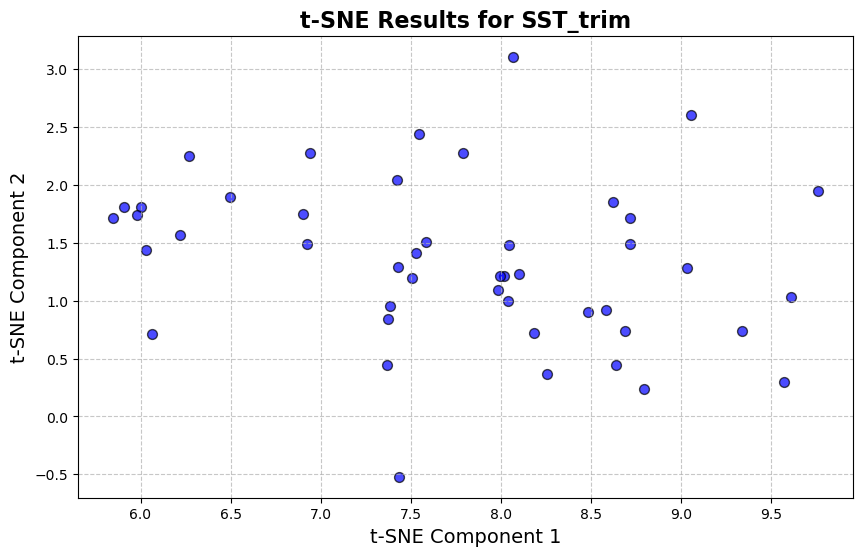

In [25]:
# Plot t-SNE results for SST with enhanced visualization
plt.figure(figsize=(10, 6))
plt.scatter(sst_tsne[:, 0], sst_tsne[:, 1], c='blue', edgecolor='k', s=50, alpha=0.7)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.title('t-SNE Results for SST_trim', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

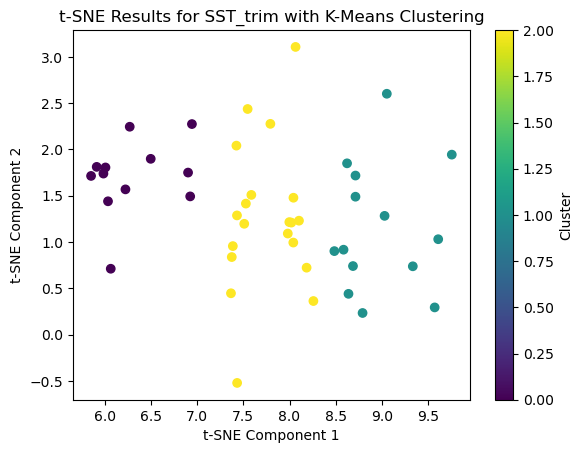

In [26]:
from sklearn.cluster import KMeans

# Perform k-means clustering on the t-SNE results
kmeans = KMeans(n_clusters=3, random_state=42)
sst_tsne_clusters = kmeans.fit_predict(sst_tsne)

# Plot the clustered t-SNE results
plt.scatter(sst_tsne[:, 0], sst_tsne[:, 1], c=sst_tsne_clusters, cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Results for SST_trim with K-Means Clustering')
plt.colorbar(label='Cluster')
plt.show()

Three clusters here seemed logical...

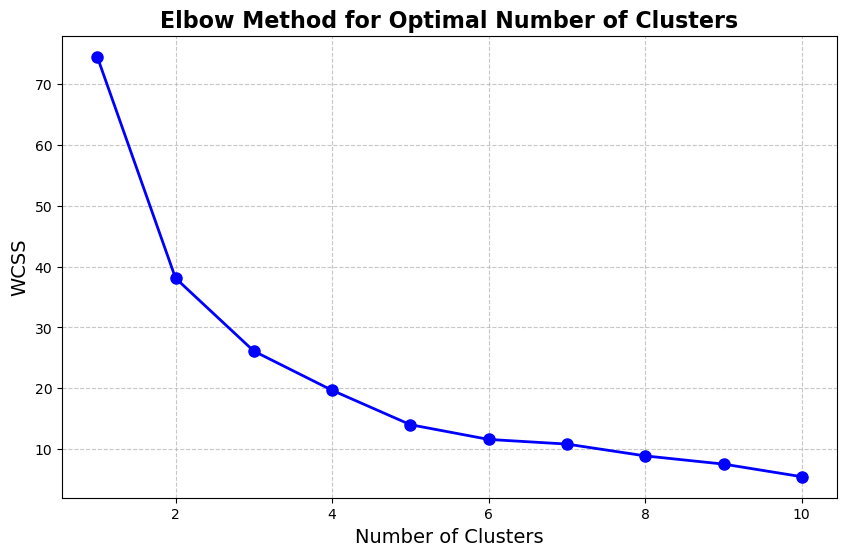

In [27]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(sst_tsne)
    wcss.append(kmeans.inertia_)

# Plot the Elbow method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b', markersize=8, linewidth=2)
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('WCSS', fontsize=14)
plt.title('Elbow Method for Optimal Number of Clusters', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

6 clusters is ideal; however, given the relativley small sample here 3 shall be used

In [28]:
from sklearn.manifold import TSNE

# Mask zeros in sic_trim
sic_trim_masked = np.ma.masked_equal(sic_trim, 0)
print(np.min(abs(sic_trim_masked)))  # No zeros left

# Perform t-Distributed Stochastic Neighbor Embedding (t-SNE) for SIC
tsne_sic = TSNE(n_components=2, random_state=42)
sic_tsne = tsne_sic.fit_transform(sic_trim_masked)
print(sic_tsne.shape)

1.5258789e-05


(46, 2)


Text(0.5, 1.0, 't-SNE Results for SIC_trim')

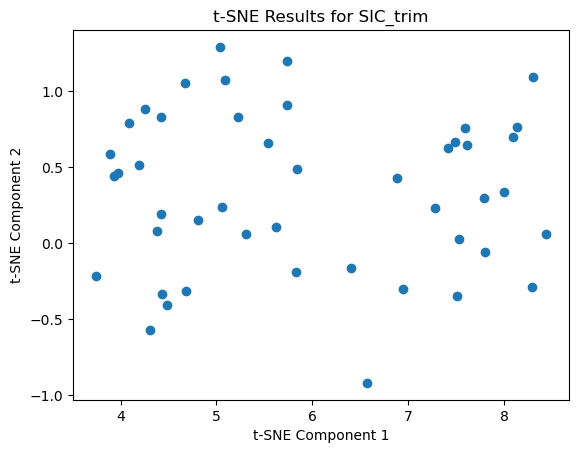

In [29]:
# Plot t-SNE results for SST
plt.scatter(sic_tsne[:, 0], sic_tsne[:, 1])
# Labels
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Results for SIC_trim')

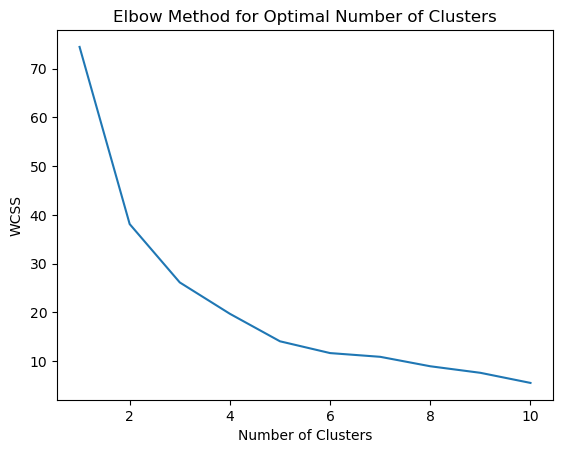

In [30]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(sst_tsne)
    wcss.append(kmeans.inertia_)

# Plot the Elbow method results
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

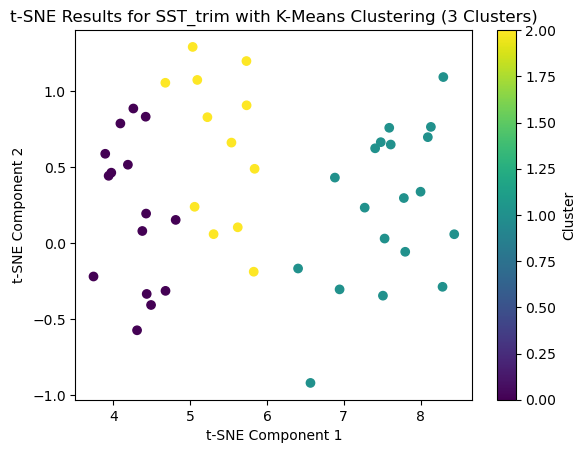

In [31]:
# Perform k-means clustering on the t-SNE results with 3 clusters
kmeans_3_clusters = KMeans(n_clusters=3, random_state=42)
sic_tsne_clusters_3 = kmeans_3_clusters.fit_predict(sic_tsne)

# Plot the clustered t-SNE results with 3 clusters
plt.scatter(sic_tsne[:, 0], sic_tsne[:, 1], c=sic_tsne_clusters_3, cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Results for SST_trim with K-Means Clustering (3 Clusters)')
plt.colorbar(label='Cluster')
plt.show()

(92, 2)


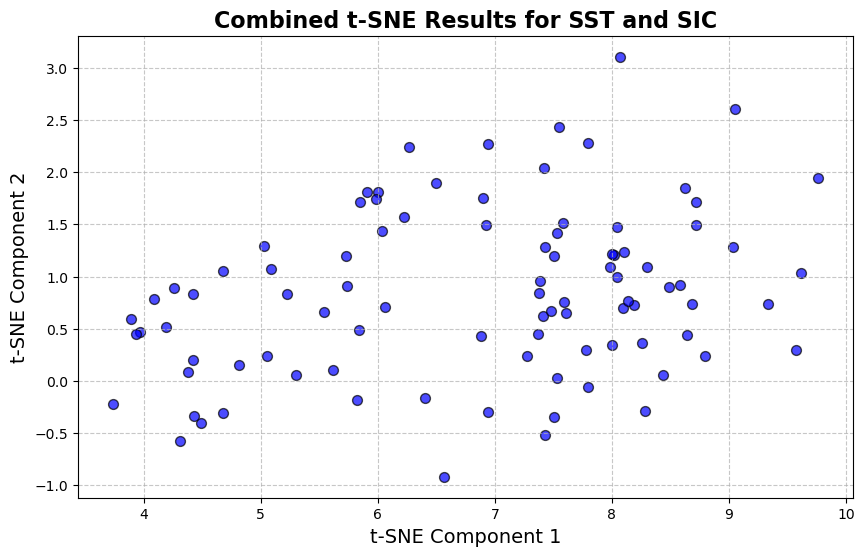

In [32]:
# Combine sic_tsne and sst_tsne
combined_tsne = np.concatenate((sst_tsne, sic_tsne), axis=0)
print(combined_tsne.shape)

# Plot combined t-SNE results with enhanced visualization
plt.figure(figsize=(10, 6))
plt.scatter(combined_tsne[:, 0], combined_tsne[:, 1], c='blue', edgecolor='k', s=50, alpha=0.7)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.title('Combined t-SNE Results for SST and SIC', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

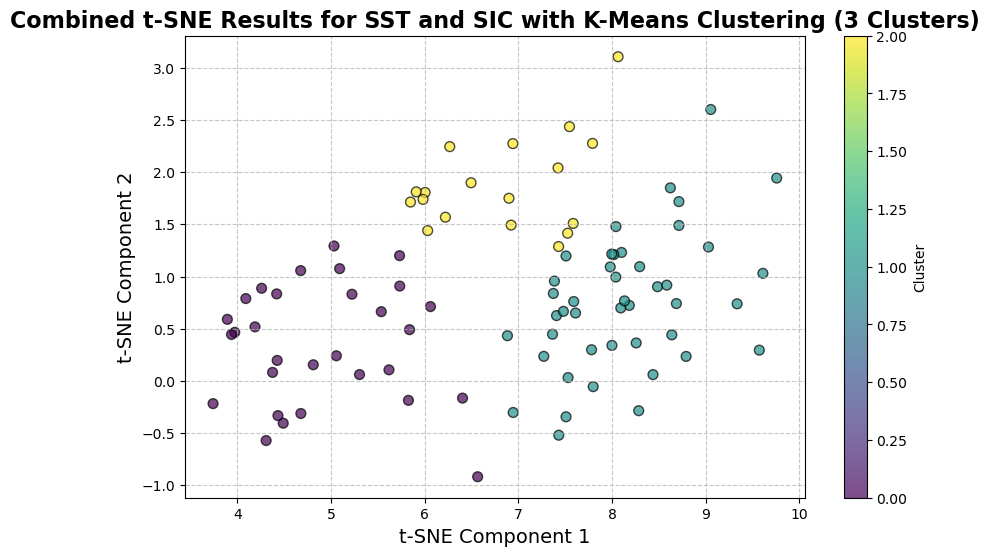

In [33]:
#Again making 3-clusters seems logical
# Perform k-means clustering on the combined t-SNE results with 3 clusters
kmeans_3_clusters_combined = KMeans(n_clusters=3, random_state=42)
combined_tsne_clusters_3 = kmeans_3_clusters_combined.fit_predict(combined_tsne)

# Plot the clustered combined t-SNE results with enhanced visualization
plt.figure(figsize=(10, 6))
plt.scatter(combined_tsne[:, 0], combined_tsne[:, 1], c=combined_tsne_clusters_3, cmap='viridis', edgecolor='k', s=50, alpha=0.7)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.title('Combined t-SNE Results for SST and SIC with K-Means Clustering (3 Clusters)', fontsize=16, fontweight='bold')
plt.colorbar(label='Cluster')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


###Discuss the implications of dimensionality reduction on your dataset.###

From our analaysis one can both visualize areas important to replicate e.g. when only looking at SST and SIC in the highest latitudes one can see that (from our EOFs) oen can see a dipole pattern across the arctic with the Canadian archipeligo opposing the ocean above Siberia. Noting that we only consider the first EOF as it by far explains the most vairence of SIC and SST. Therefore, it is important to include smaple from both sides of the arctic. T-SNE analssis further shows us that when collopsing our data into 2 dimensions in both SIC and SST there is the oppurtunity to represent our data by only two attriubutes in three areas if we just collapse our data down e.g. we need not include a hole map but nodes from this reduced data set. Natrually, the current dimesnions are too high, but by analyzing a few regions (e.g. the dipole) or by reducing to 2D and using an average of our cluster we might reduce our data set sufficently. Moreover, while PCA and T-SNE did not provide the knockout blow we were looking for to reduce the size of the data (e.g. the first resoanble EOF without choosing very hihg latitudes only expalins 30-40% of the vairance), whereas, we would want closer to 80% to redeuce this information. Therefore, for neither SST or SIC it makes sense to reduce using PCA across the dmain we are interested in; however, we could regionally do PCA in the futrue and have different data reductions for different regions. That being said, it is not a surpise this did not fully reduce to something more explainable due to the dynamic nature of the climate system.